# Stability Time Analysis with Single Cell Data

This notebook performs comprehensive differential expression analysis of stability across time points including single cell data. The analysis includes DESeq2 normalization, batch correction, PCA visualization, and differential expression testing.

## Analysis Overview
- **Input**: Bulk RNA-seq count data with time point and single cell metadata
- **Processing**: Quality control, normalization, batch correction
- **Analysis**: PCA, differential expression, distance calculations
- **Output**: Normalized counts, distance matrices, volcano plots

## Key Components
1. Data loading and quality control
2. DESeq2 normalization and filtering
3. Batch effect correction using limma
4. PCA analysis and visualization
5. Differential expression analysis
6. Distance calculations for reproducibility assessment
7. Marker gene analysis

**Note**: This analysis extends the basic stability analysis by incorporating single cell reference data for enhanced interpretation.

## Configuration

In [ ]:
# Configuration parameters
CONFIG <- list(
  # Input files
  count_data_file = "bulk/stability_timepoints_wSC.tsv",
  metadata_file = "bulk/stability_timepoints_meta_wSC.tsv",
  marker_genes_sc = "sample_markers_all_sc_set_top3_10genes.txt",
  marker_genes_bulk = "sample_markers_all_sc_set_top3_10genes_bulk.txt",
  
  # Analysis parameters
  min_count_threshold = 0,  # Minimum count threshold for sample filtering
  min_gene_count = 10,      # Minimum total count per gene for filtering
  top_genes_heatmap = 20,   # Number of top genes for heatmap
  
  # Statistical parameters
  p_cutoff = 0.05,
  fc_cutoff = 1,
  lfc_threshold = 1,
  
  # Output files
  output_dir = "bulk/",
  
  # Plot parameters
  plot_width = 8,
  plot_height = 8,
  heatmap_width = 15,
  heatmap_height = 40,
  
  # Random seed for reproducibility
  seed = 123
)

# Set random seed
set.seed(CONFIG$seed)

# Print configuration
cat("Configuration loaded successfully\n")
cat("Input files:", CONFIG$count_data_file, "and", CONFIG$metadata_file, "\n")
cat("Minimum count threshold:", CONFIG$min_count_threshold, "\n")

## Load Required Libraries

In [ ]:
# Load required libraries with error handling
required_packages <- c(
  "DESeq2", "useful", "ggplot2", "dplyr", "limma", 
  "EnhancedVolcano", "biomaRt", "gridExtra", "repr",
  "vsn", "pheatmap", "RColorBrewer"
)

# Function to load packages with error handling
load_package <- function(pkg) {
  if (!requireNamespace(pkg, quietly = TRUE)) {
    stop(paste("Package", pkg, "is required but not installed"))
  }
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}

# Load all packages
sapply(required_packages, load_package)

# Print package versions for reproducibility
cat("Package versions:\n")
for (pkg in required_packages) {
  cat(paste(pkg, ":", packageVersion(pkg), "\n"))
}

Possible Ensembl SSL connectivity problems detected.
Please see the 'Connection Troubleshooting' section of the biomaRt vignette
vignette('accessing_ensembl', package = 'biomaRt')Error in curl::curl_fetch_memory(url, handle = handle) : 
  SSL certificate problem: certificate has expired




## Data Loading and Initial Exploration

In [ ]:
# Load count data and metadata with error handling
if (!file.exists(CONFIG$count_data_file)) {
  stop(paste("Count data file not found:", CONFIG$count_data_file))
}
if (!file.exists(CONFIG$metadata_file)) {
  stop(paste("Metadata file not found:", CONFIG$metadata_file))
}

data <- read.csv(CONFIG$count_data_file, sep="\t", header=T, quote="", row.names=1)
meta <- read.csv(CONFIG$metadata_file, sep="\t", header=T, row.names=1, quote="")

# Display data overview
cat("Count data dimensions:", dim(data), "\n")
cat("Metadata dimensions:", dim(meta), "\n")
corner(data)
cat("\nMetadata structure:\n")
head(meta)

,Stability_d21_sample_9,Stability_d21_sample_4,Stability_d21_sample_5,Stability_d21_sample_10,Stability_d21_sample_7
,<int>,<int>,<int>,<int>,<int>
5S_rRNA,0,6,0,0,0
5_8S_rRNA,0,0,0,0,0
7SK,0,0,0,0,1
A1BG,3,6,5,4,21
A1BG-AS1,5,13,11,4,4


## Quality Control and Sample Filtering

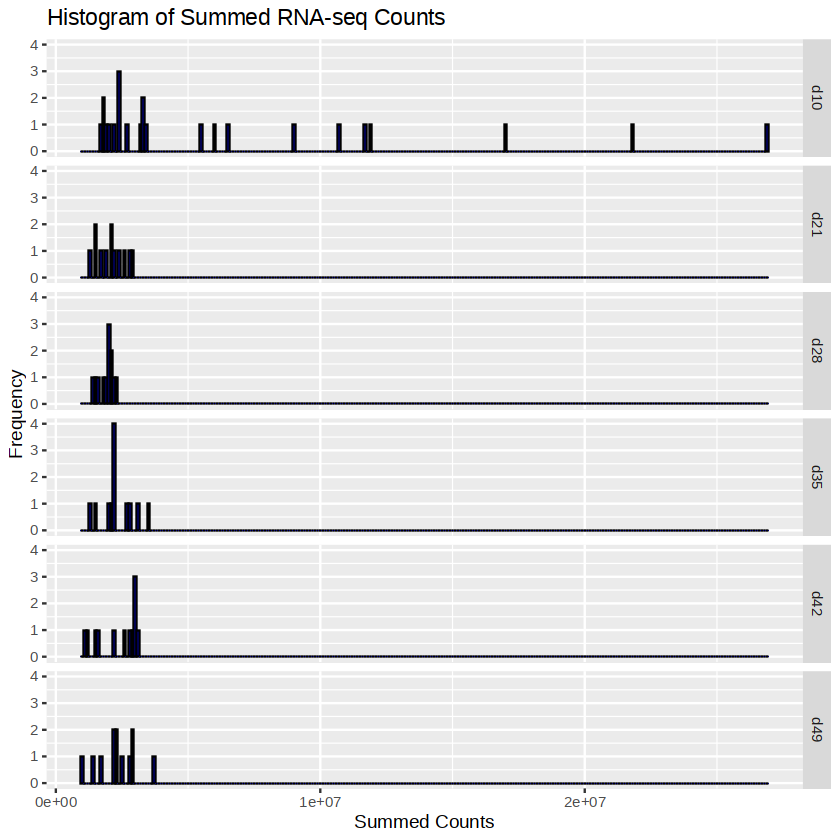

                         counts
Stability_d49_sample_1   992641
Stability_d42_sample_12 1079041
Stability_d42_sample_11 1180100
Stability_d35_sample_1  1284177
Stability_d21_sample_1  1303492
Stability_d49_sample_2  1376227
Stability_d28_sample_5  1426088
Stability_d21_sample_2  1455183
Stability_d35_sample_2  1463416
Stability_d21_sample_9  1490147
Stability_d42_sample_10 1497309
Stability_d28_sample_12 1509340
Stability_d42_sample_9  1621425
Stability_d28_sample_4  1643799
Stability_d21_sample_4  1665449
Stability_d10_sample_12 1697202
Stability_d49_sample_3  1717313
Stability_d28_sample_6  1805606
Stability_d10_sample_11 1819786
Stability_d10_sample_9  1849247


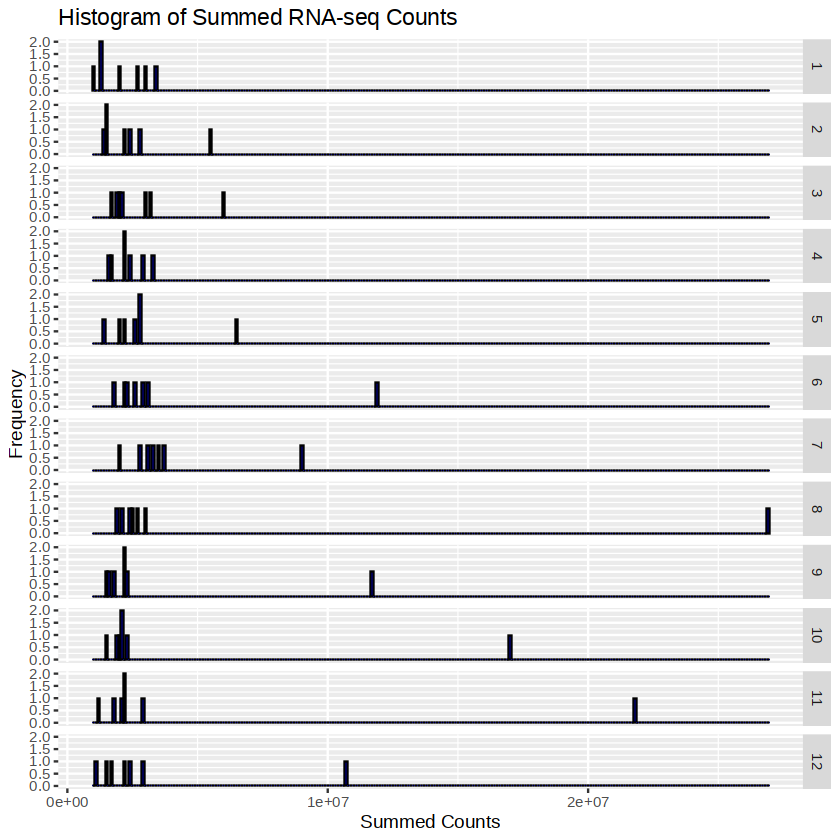

In [ ]:
# Load your dataset
# Replace 'your_dataset.csv' with the path to your RNA-seq counts file
# and make sure the column containing counts is correctly specified.

# Quality control: analyze library sizes and sample characteristics
counts <- colSums(data)
meta['counts'] <- counts

# Create comprehensive QC plots
library_size_plot1 <- ggplot(meta, aes(x = counts)) +
  geom_histogram(binwidth = 100000, fill = 'blue', color = 'black', alpha = 0.7) +
  ggtitle('Distribution of Library Sizes Across Samples') +
  xlab('Total Counts per Sample') +
  ylab('Frequency') +
  facet_grid(t ~ .) +
  theme_bw()

library_size_plot2 <- ggplot(meta, aes(x = counts)) +
  geom_histogram(binwidth = 100000, fill = 'blue', color = 'black', alpha = 0.7) +
  ggtitle('Distribution of Library Sizes by Sample') +
  xlab('Total Counts per Sample') +
  ylab('Frequency') +
  facet_grid(sample ~ .) +
  theme_bw()

# Display plots
print(library_size_plot1)
print(library_size_plot2)

# Show lowest count samples for potential filtering
lowest_counts <- data.frame(counts = counts) %>% 
  arrange(counts) %>% 
  head(20)

cat("Samples with lowest library sizes:\n")
print(lowest_counts)


In [ ]:
# Sample filtering based on library size
cat("Applying sample filtering...\n")
cat("Minimum count threshold:", CONFIG$min_count_threshold, "\n")

# Apply filtering
samples_before <- ncol(data)
filtered_data <- data[, colSums(data) >= CONFIG$min_count_threshold]
filtered_meta <- meta[colSums(data) >= CONFIG$min_count_threshold, ]
samples_after <- ncol(filtered_data)

# Report filtering results
cat("Samples before filtering:", samples_before, "\n")
cat("Samples after filtering:", samples_after, "\n")
cat("Samples removed:", samples_before - samples_after, "\n")

if (samples_after == 0) {
  stop("All samples filtered out! Check minimum count threshold.")
}

cat("Final dataset dimensions:\n")
cat("Count data:", dim(filtered_data), "\n")
cat("Metadata:", dim(filtered_meta), "\n")


## DESeq2 Setup and Preprocessing

In [ ]:
# Prepare metadata for DESeq2 analysis
cat("Preparing metadata for DESeq2...\n")

# Initialize colData from filtered metadata
deseq2.colData <- filtered_meta
deseq2.colData['sums'] <- colSums(filtered_data)

# Convert categorical variables to factors
columns_to_factor <- c("sample", "t")
deseq2.colData <- deseq2.colData %>%
  mutate_at(vars(all_of(columns_to_factor)), factor)

# Scale numeric variables for analysis
numeric_columns_to_scale <- c("t_int")
if (all(numeric_columns_to_scale %in% colnames(deseq2.colData))) {
  deseq2.colData <- deseq2.colData %>%
    mutate_at(vars(all_of(numeric_columns_to_scale)), ~ scale(log(. + 1)))
  cat("Scaled numeric columns:", paste(numeric_columns_to_scale, collapse=", "), "\n")
} else {
  warning("Some numeric columns not found in metadata")
}

cat("Metadata prepared successfully\n")
cat("Available columns:", paste(colnames(deseq2.colData), collapse=", "), "\n")

In [ ]:
# Display prepared metadata summary
cat("Final metadata structure:\n")
corner(deseq2.colData)
cat("\nSample distribution:\n")
table(deseq2.colData$sample)
cat("\nTime point distribution:\n")
table(deseq2.colData$t)

,t,sample,t_int,genotype,repl
,<chr>,<int>,<int>,<chr>,<int>
Stability_d21_sample_9,d21,9,21,409B2,1
Stability_d21_sample_4,d21,4,21,409B2,1
Stability_d21_sample_5,d21,5,21,409B2,1
Stability_d21_sample_10,d21,10,21,409B2,1
Stability_d21_sample_7,d21,7,21,409B2,1


In [ ]:
# Create DESeq2 dataset object
cat("Creating DESeq2 dataset...\n")

# Ensure rownames match
total <- filtered_data
rownames(deseq2.colData) <- colnames(total)

# Verify that all samples in data have corresponding metadata
if (!all(colnames(total) %in% rownames(deseq2.colData))) {
  stop("Sample names in count data don't match metadata rownames")
}

# Create DESeq dataset with experimental design
# Design includes time, sample, and genotype effects
design_formula <- ~ t_int + sample + genotype
cat("Using design formula:", deparse(design_formula), "\n")

dds <- DESeqDataSetFromMatrix(
  countData = total, 
  colData = deseq2.colData,
  design = design_formula
)

cat("DESeq2 dataset created successfully\n")
cat("Samples:", ncol(dds), "\n")
cat("Genes:", nrow(dds), "\n")

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"


In [ ]:
# Gene filtering and DESeq2 analysis
cat("Filtering low-count genes...\n")

# Filter genes with low total counts
genes_before <- nrow(dds)
keep <- rowSums(counts(dds)) >= CONFIG$min_gene_count
dds <- dds[keep,]
genes_after <- nrow(dds)

cat("Genes before filtering:", genes_before, "\n")
cat("Genes after filtering:", genes_after, "\n")
cat("Genes removed:", genes_before - genes_after, "\n")

# Run DESeq2 analysis
cat("Running DESeq2 analysis...\n")
dds <- DESeq(dds)

# Get results
res <- results(dds)
res <- res[order(rownames(res)), ]

cat("DESeq2 analysis completed successfully\n")
cat("Results summary:\n")
summary(res)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [ ]:
# Check model convergence
convergence_table <- table(mcols(dds)$betaConv)
cat("Model convergence status:\n")
print(convergence_table)

if (any(names(convergence_table) == "FALSE")) {
  cat("Warning: Some coefficients did not converge\n")
} else {
  cat("All coefficients converged successfully\n")
}


 TRUE 
35775 

## Data Normalization and Transformation

In [ ]:
# Extract and save normalized counts
cat("Extracting normalized counts...\n")
normalized_counts <- counts(dds, normalized=TRUE)

# Optional: save normalized counts
output_file <- file.path(CONFIG$output_dir, "stability_time_normalized_counts_wSC.tsv")
# write.table(normalized_counts, file=output_file, sep="\t", quote=F, col.names=NA)

cat("Normalized counts matrix dimensions:", dim(normalized_counts), "\n")
cat("Sample normalized count ranges:\n")
print(summary(colSums(normalized_counts)))

In [ ]:
# Variance stabilizing transformation for downstream analysis
cat("Applying variance stabilizing transformation...\n")
vsd <- vst(dds, blind=FALSE)
vsd_orig <- vsd  # Keep original for comparison

cat("VST transformation completed\n")
cat("Transformed data dimensions:", dim(assay(vsd)), "\n")

## Batch Correction and PCA Analysis

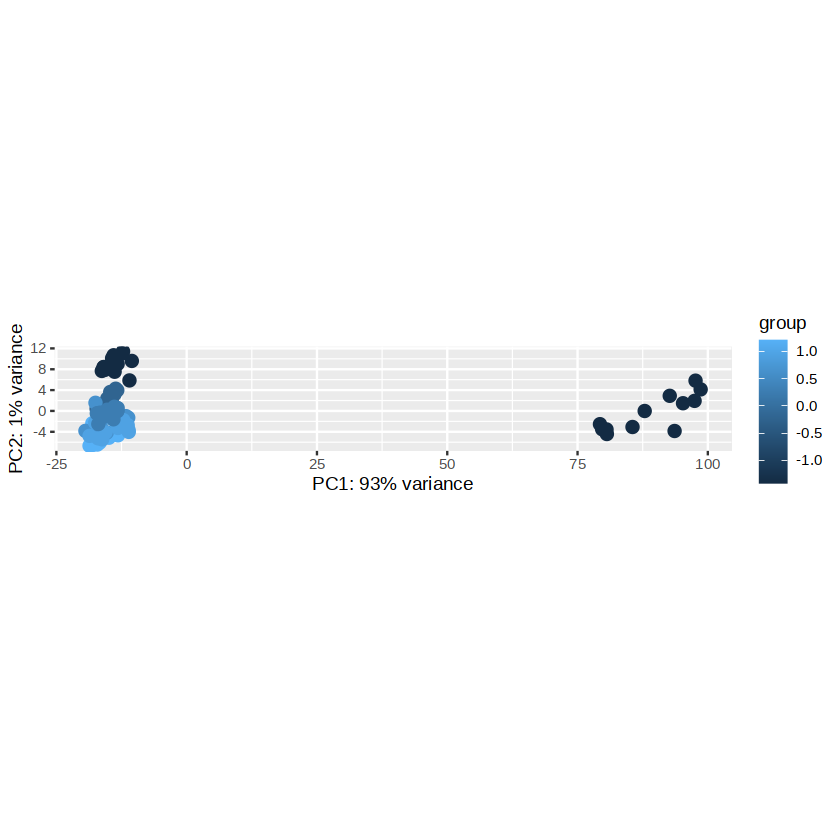

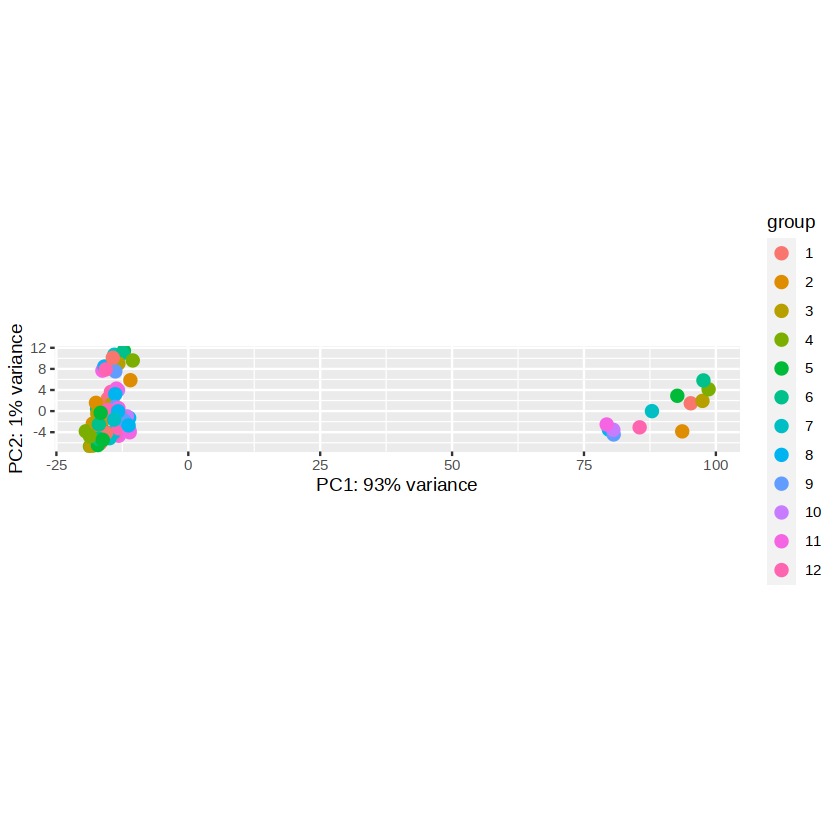

In [ ]:
# Batch correction: Remove sample effects while preserving time effects
cat("Performing batch correction for sample effects...\n")

# Function to perform batch correction and generate PCA plots
perform_batch_correction <- function(vsd_obj, batch_var, design_var, correction_name) {
  cat(paste("Correcting for", batch_var, "while preserving", design_var, "\n"))
  
  vsd_corrected <- vsd_obj
  mat <- assay(vsd_corrected)
  mm <- model.matrix(as.formula(paste("~", design_var)), colData(vsd_corrected))
  
  # Get batch variable
  batch_values <- colData(vsd_corrected)[[batch_var]]
  mat <- limma::removeBatchEffect(mat, batch=batch_values, design=mm)
  assay(vsd_corrected) <- mat
  
  # Generate PCA plots
  options(repr.plot.width=12, repr.plot.height=5)
  p1 <- plotPCA(vsd_corrected, intgroup=c(design_var)) + 
    ggtitle(paste("PCA after", correction_name, "correction -", design_var))
  p2 <- plotPCA(vsd_corrected, intgroup=c(batch_var)) + 
    ggtitle(paste("PCA after", correction_name, "correction -", batch_var))
  
  print(p1)
  print(p2)
  
  return(vsd_corrected)
}

# Correct for sample effects while preserving time effects
vsd_samplecorr <- perform_batch_correction(vsd, "sample", "t_int", "sample")

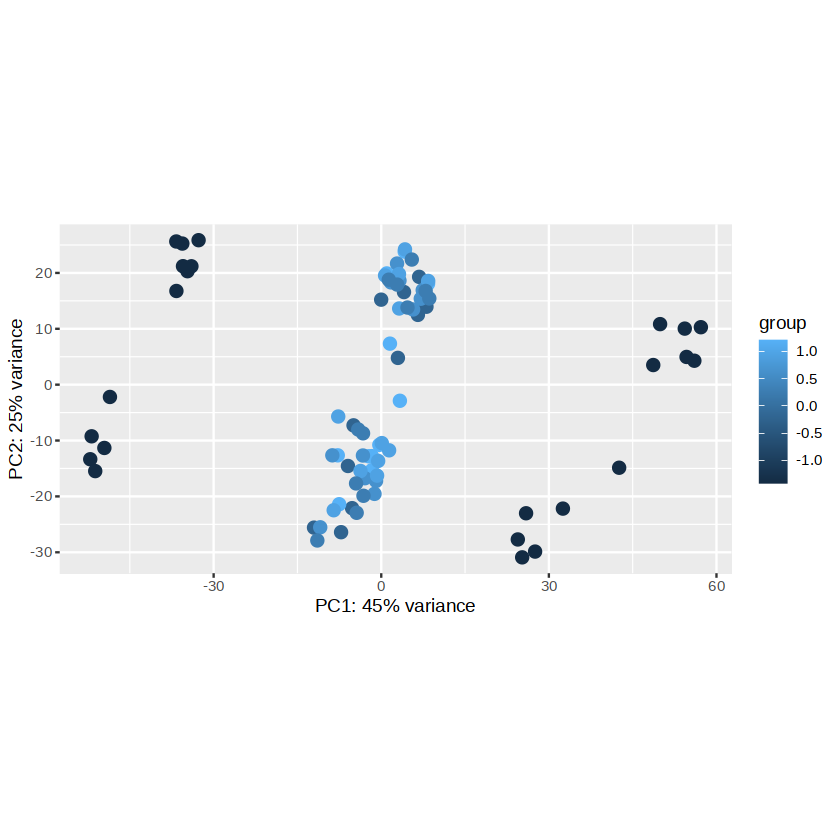

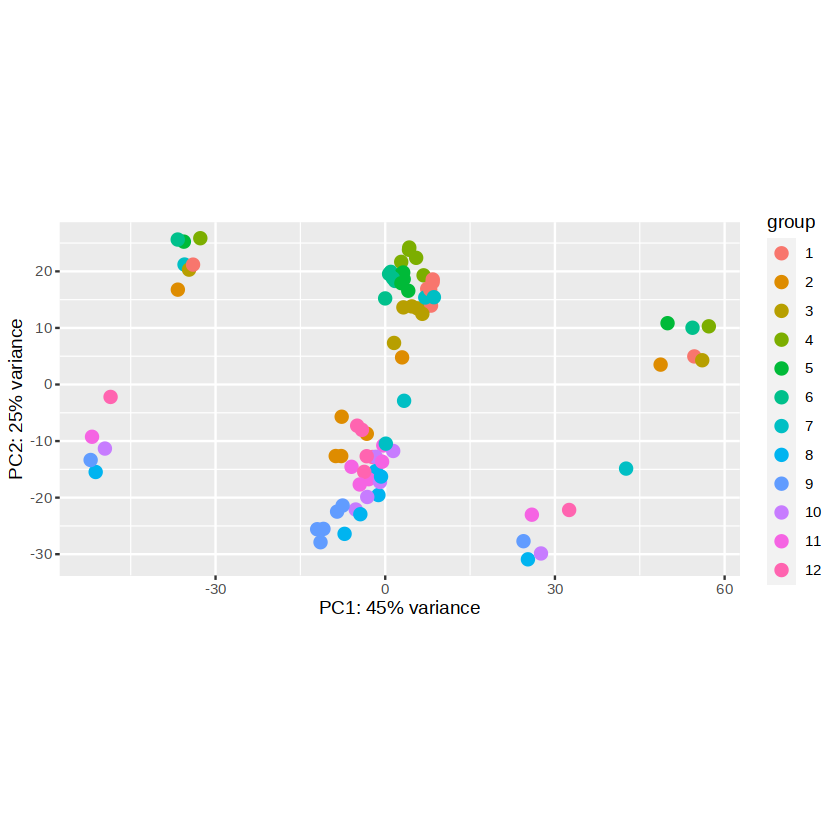

In [ ]:
vsd_bk <- vsd
mat <- assay(vsd_bk)
mm <- model.matrix(~sample, colData(vsd_bk))
mat <- limma::removeBatchEffect(mat, batch=vsd_bk$t_int, design=mm)
assay(vsd_bk) <- mat
plotPCA(vsd_bk,intgroup=c('t_int'))
plotPCA(vsd_bk,intgroup=c('sample'))
# Correct for time effects while preserving sample effects
vsd_tcorr <- perform_batch_correction(vsd, "t_int", "sample", "time")

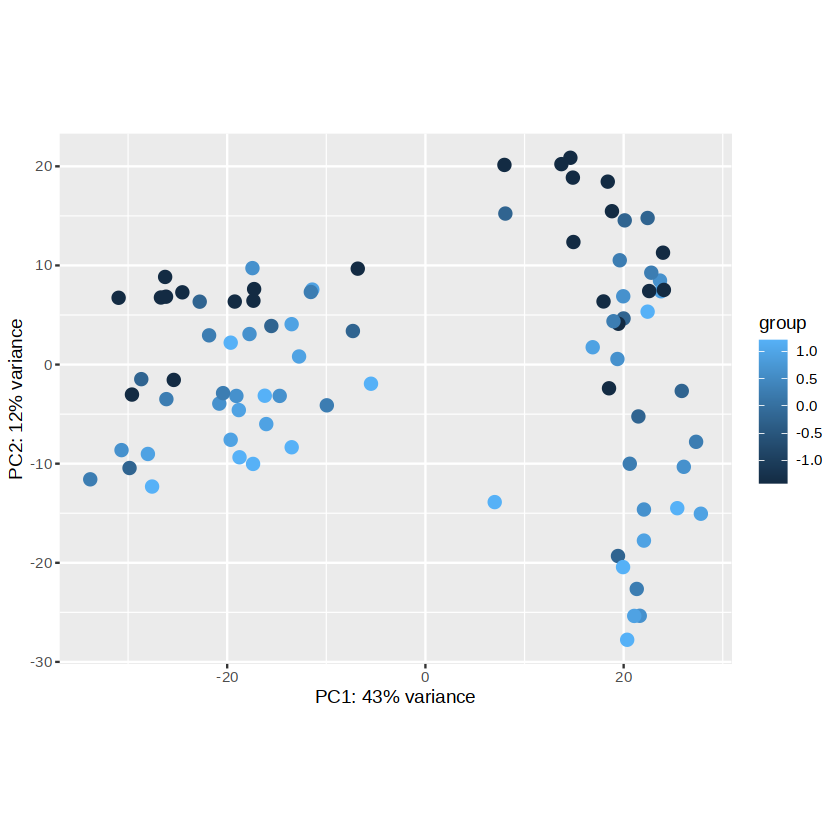

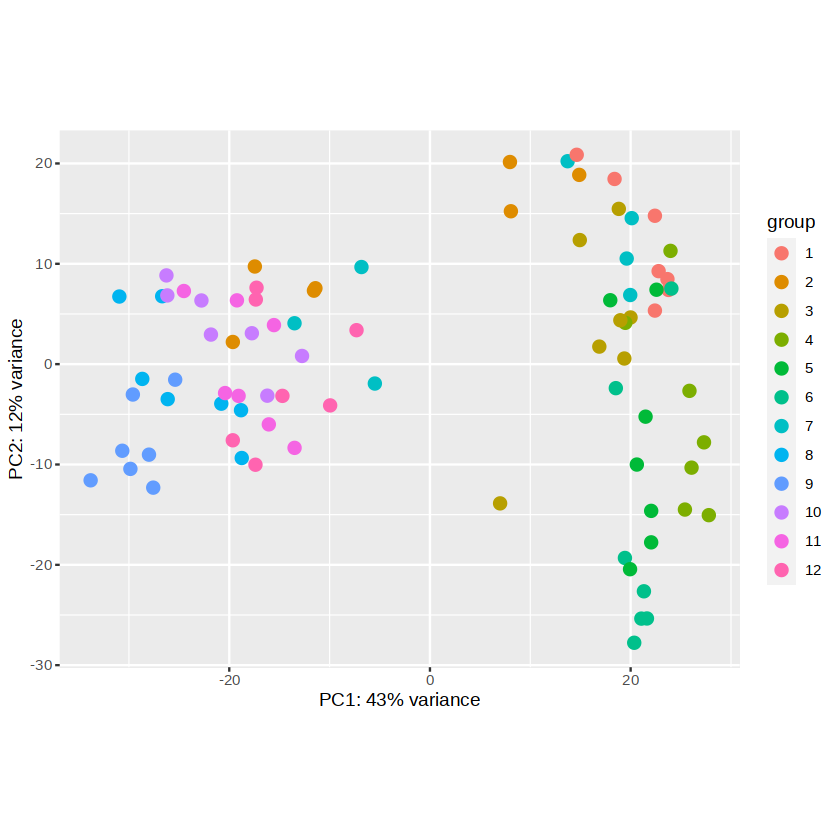

In [ ]:
vsd_bk <- vsd
mat <- assay(vsd_bk)
mm <- model.matrix(~t_int, colData(vsd_bk))
mat <- limma::removeBatchEffect(mat, batch=vsd_bk$genotype, design=mm)
assay(vsd_bk) <- mat
plotPCA(vsd_bk,intgroup=c('t_int'))
plotPCA(vsd_bk,intgroup=c('sample'))
# Correct for genotype effects while preserving time effects
vsd_gencorr <- perform_batch_correction(vsd, "genotype", "t_int", "genotype")

## Data Quality Assessment

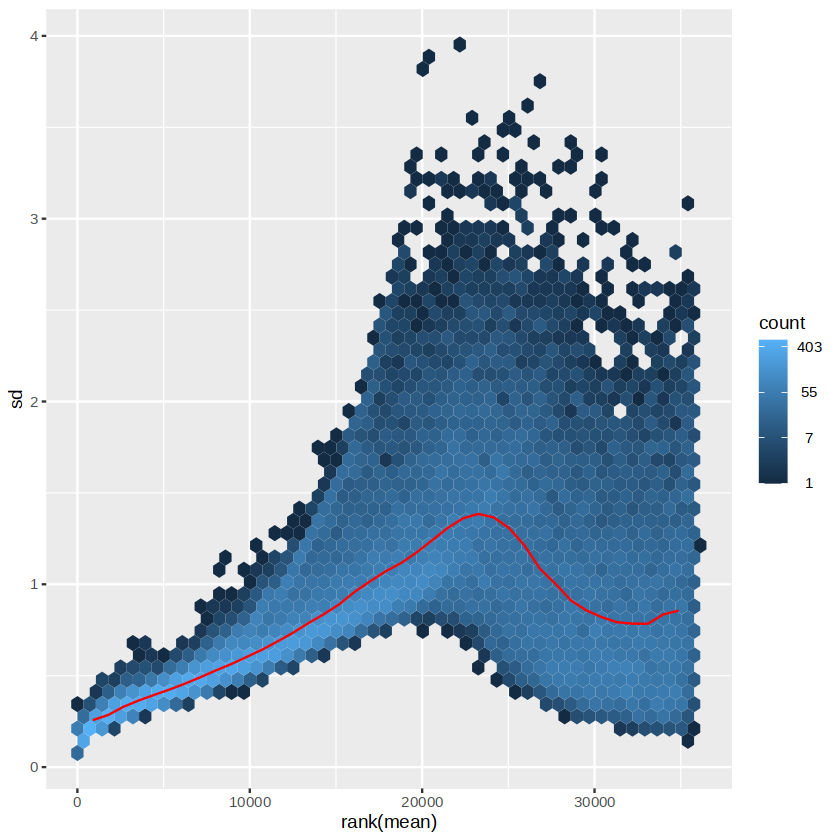

In [ ]:
# Quality assessment: variance-mean relationship
cat("Assessing data quality with mean-variance plots...\n")

# Normal transformation for comparison
ntd <- normTransform(dds)

# Mean-variance relationship plot
options(repr.plot.width=8, repr.plot.height=6)
meanSdPlot(assay(ntd), main="Normal transformation (log2)")

cat("Mean-variance plot generated for quality assessment\n")

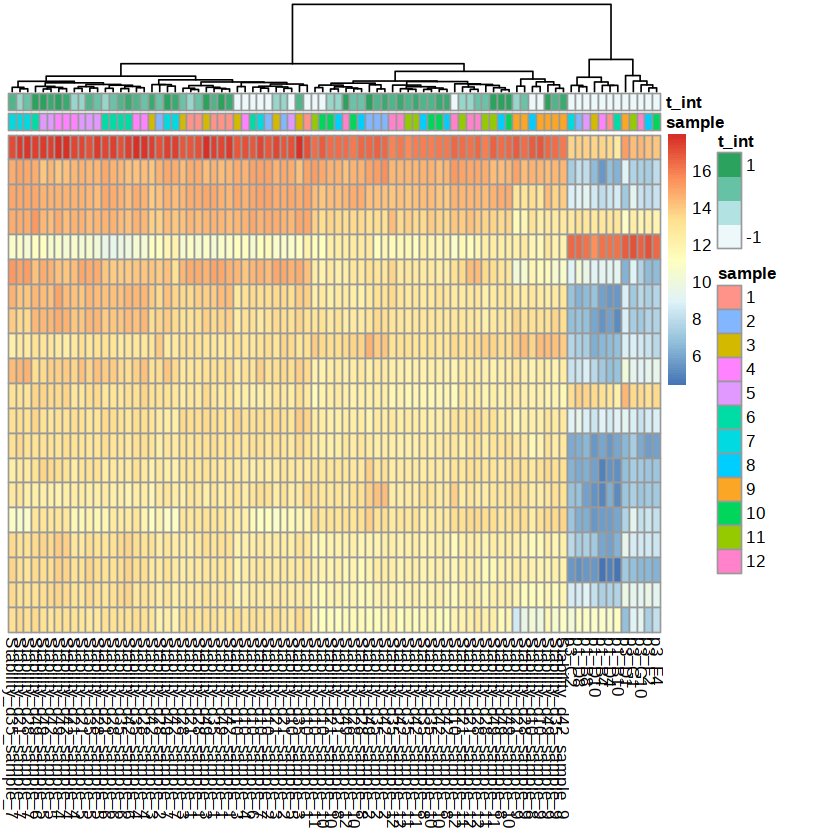

In [ ]:
library("pheatmap")

# Heatmap of top expressed genes (normal transformation)
cat("Generating heatmap of top expressed genes...\n")

options(repr.plot.width=10, repr.plot.height=8)

# Select top expressed genes
select <- order(rowMeans(counts(dds, normalized=TRUE)), 
                decreasing=TRUE)[1:CONFIG$top_genes_heatmap]

# Prepare annotation
df <- as.data.frame(colData(dds)[,c("sample","t_int")])

# Generate heatmap
pheatmap(assay(ntd)[select,], 
         cluster_rows=FALSE, 
         show_rownames=FALSE,
         cluster_cols=TRUE, 
         annotation_col=df,
         main="Top expressed genes (normal transformation)")

cat("Heatmap generated with top", CONFIG$top_genes_heatmap, "genes\n")

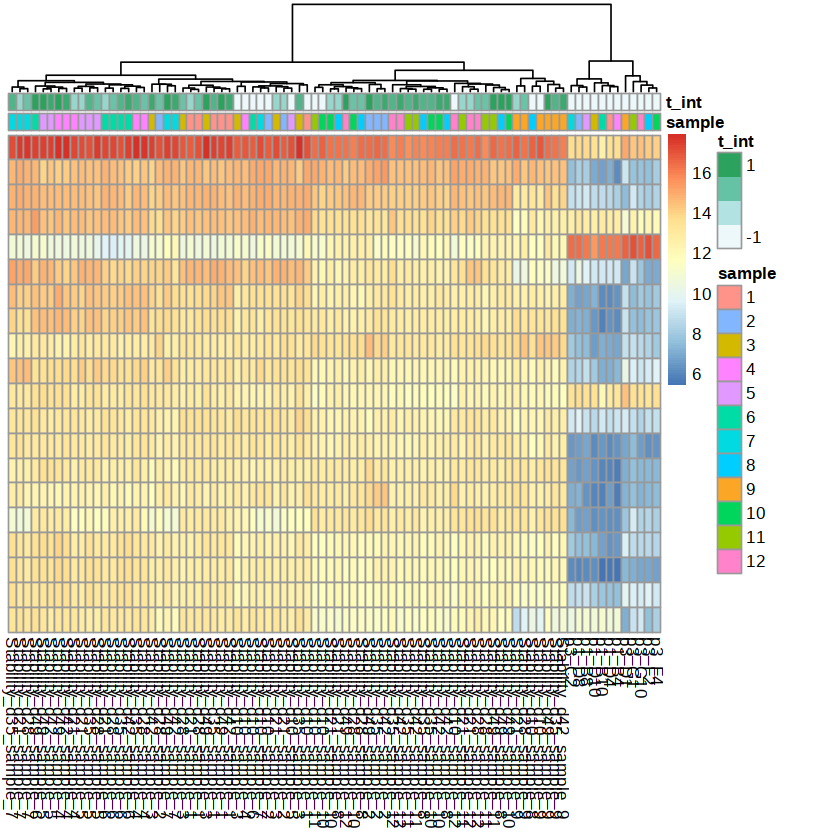

In [ ]:
library("pheatmap")
select <- order(rowMeans(counts(dds,normalized=TRUE)),
                decreasing=TRUE)[1:20]
df <- as.data.frame(colData(dds)[,c("sample","t_int")])
# Heatmap of top expressed genes (VST transformation)
cat("Generating VST heatmap...\n")

pheatmap(assay(vsd)[select,], 
         cluster_rows=FALSE, 
         show_rownames=FALSE,
         cluster_cols=TRUE, 
         annotation_col=df,
         main="Top expressed genes (VST transformation)")

cat("VST heatmap generated\n")

## Distance Calculations for Reproducibility Assessment

In [ ]:
# Calculate sample distances for different transformations
cat("Calculating sample distances for reproducibility assessment...\n")

# Function to calculate and save distances
calculate_and_save_distances <- function(vsd_obj, output_suffix) {
  sampleDists <- dist(t(assay(vsd_obj)))
  dist_matrix <- as.data.frame(as.matrix(sampleDists))
  
  output_file <- file.path(CONFIG$output_dir, 
                          paste0("stability_time_deseq2_", output_suffix, "_distances_wSC.tsv"))
  write.table(dist_matrix, output_file, sep = "\t")
  
  cat("Saved distances:", output_file, "\n")
  return(dist_matrix)
}

# Calculate distances for different corrections
distances_orig <- calculate_and_save_distances(vsd_orig, "original")
distances_samplecorr <- calculate_and_save_distances(vsd_samplecorr, "samplecorr")
distances_tcorr <- calculate_and_save_distances(vsd_tcorr, "timecorr")
distances_gencorr <- calculate_and_save_distances(vsd_gencorr, "genotypecorr")

cat("Distance calculations completed\n")


In [ ]:
# Export VST-transformed data for different corrections
cat("Exporting VST-transformed expression data...\n")

# Function to export VST data
export_vst_data <- function(vsd_obj, output_suffix) {
  output_file <- file.path(CONFIG$output_dir, 
                          paste0("stability_time_deseq2_vsd_", output_suffix, "_wSC.tsv"))
  write.table(assay(vsd_obj), output_file, sep = "\t")
  cat("Exported VST data:", output_file, "\n")
}

# Export different transformations
export_vst_data(vsd_orig, "original")
export_vst_data(vsd_samplecorr, "samplecorr")
export_vst_data(vsd_tcorr, "timecorr")
export_vst_data(vsd_gencorr, "genotypecorr")

cat("VST data export completed\n")


## Marker Gene Analysis

In [ ]:
# Load single cell marker genes and calculate distances
cat("Loading single cell marker genes...\n")

if (!file.exists(CONFIG$marker_genes_sc)) {
  warning(paste("Single cell marker file not found:", CONFIG$marker_genes_sc))
  marker_genes_sc <- NULL
} else {
  marker_genes_sc_df <- read.csv(CONFIG$marker_genes_sc, sep="\t", header=F, quote="", row.names=1)
  marker_genes_sc <- row.names(marker_genes_sc_df)
  cat("Loaded", length(marker_genes_sc), "single cell marker genes\n")
  
  # Calculate distances using SC markers
  if (all(marker_genes_sc %in% rownames(assay(vsd_gencorr)))) {
    sampleDists_sc <- dist(t(assay(vsd_gencorr)[marker_genes_sc,]))
    dist_matrix_sc <- as.data.frame(as.matrix(sampleDists_sc))
    
    output_file_sc <- file.path(CONFIG$output_dir, 
                               "stability_time_deseq2_genotypecorr_distances_wSC_markers.tsv")
    write.table(dist_matrix_sc, output_file_sc, sep = "\t")
    cat("Saved SC marker distances:", output_file_sc, "\n")
  } else {
    warning("Some SC marker genes not found in expression data")
  }
}

In [ ]:
# Load bulk marker genes and calculate distances
cat("Loading bulk marker genes...\n")

if (!file.exists(CONFIG$marker_genes_bulk)) {
  warning(paste("Bulk marker file not found:", CONFIG$marker_genes_bulk))
} else {
  marker_genes_bulk_df <- read.csv(CONFIG$marker_genes_bulk, sep="\t", header=F, quote="", row.names=1)
  marker_genes_bulk <- row.names(marker_genes_bulk_df)
  cat("Loaded", length(marker_genes_bulk), "bulk marker genes\n")
  
  # Calculate distances using bulk markers
  if (all(marker_genes_bulk %in% rownames(assay(vsd_gencorr)))) {
    sampleDists_bulk <- dist(t(assay(vsd_gencorr)[marker_genes_bulk,]))
    dist_matrix_bulk <- as.data.frame(as.matrix(sampleDists_bulk))
    
    output_file_bulk <- file.path(CONFIG$output_dir, 
                                 "stability_time_deseq2_genotypecorr_distances_wSC_markers_bulk.tsv")
    write.table(dist_matrix_bulk, output_file_bulk, sep = "\t")
    cat("Saved bulk marker distances:", output_file_bulk, "\n")
  } else {
    warning("Some bulk marker genes not found in expression data")
  }
}

## Sample Distance Visualization

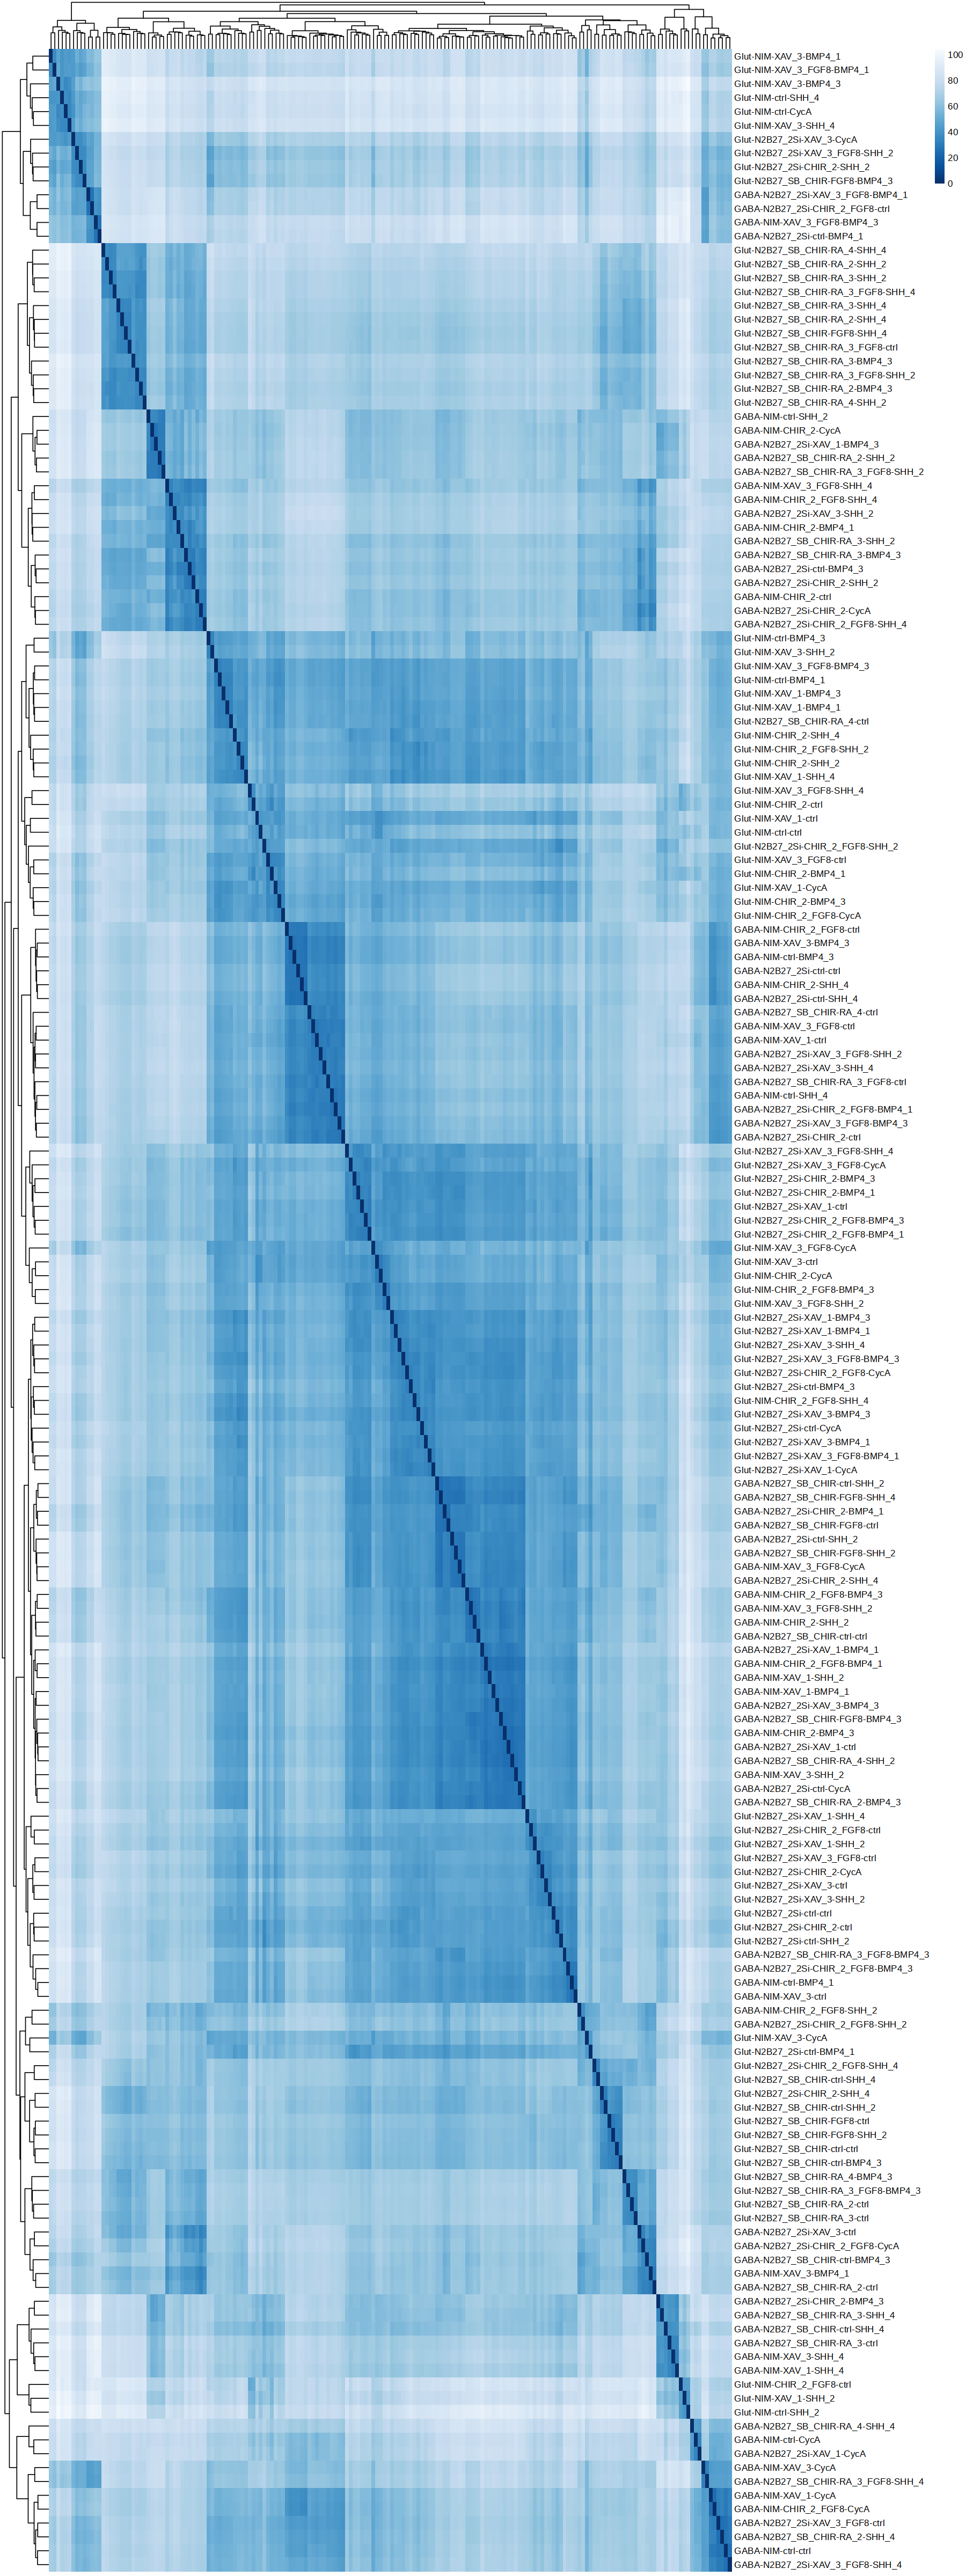

In [ ]:
library("RColorBrewer")

# Generate sample distance heatmap
cat("Creating sample distance heatmap...\n")

# Calculate sample distances for visualization
sampleDists <- dist(t(assay(vsd_gencorr)))
sampleDistMatrix <- as.matrix(sampleDists)

# Create meaningful sample labels
if ("TF" %in% colnames(colData(vsd_gencorr))) {
  # Use existing column structure if available
  sample_labels <- paste(colData(vsd_gencorr)$TF, 
                        colData(vsd_gencorr)$Basal_media, 
                        colData(vsd_gencorr)$AP_axis, 
                        colData(vsd_gencorr)$DV_axis, 
                        sep="-")
} else {
  # Fallback to simpler labeling
  sample_labels <- paste(colData(vsd_gencorr)$sample, 
                        colData(vsd_gencorr)$t, 
                        sep="-")
}

rownames(sampleDistMatrix) <- sample_labels
colnames(sampleDistMatrix) <- NULL

# Set up colors
colors <- colorRampPalette(rev(brewer.pal(9, "Blues")))(255)

# Set plot size
options(repr.plot.width=CONFIG$heatmap_width, repr.plot.height=CONFIG$heatmap_height)

# Generate heatmap
pheatmap(sampleDistMatrix,
         clustering_distance_rows=sampleDists,
         clustering_distance_cols=sampleDists,
         col=colors,
         main="Sample Distance Heatmap")

cat("Sample distance heatmap generated\n")

## Differential Expression Analysis

In [ ]:
# Differential expression analysis with shrinkage estimation
cat("Performing differential expression analysis...\n")

# Function to perform DE analysis for a specific contrast
perform_de_analysis <- function(dds_obj, contrast_name, shrink_method = "ashr") {
  cat(paste("Analyzing contrast:", contrast_name, "\n"))
  
  # Get results
  res <- results(dds_obj, name = contrast_name)
  
  # Apply shrinkage estimation
  if (shrink_method == "ashr") {
    res_shrunk <- lfcShrink(dds_obj, res=res, coef=2, type="ashr", 
                           lfcThreshold=CONFIG$lfc_threshold)
  } else if (shrink_method == "apeglm") {
    res_shrunk <- lfcShrink(dds_obj, res=res, coef=contrast_name, type="apeglm", 
                           lfcThreshold=CONFIG$lfc_threshold)
  }
  
  cat("DE analysis completed for", contrast_name, "\n")
  cat("Significant genes (p < 0.05):", sum(res$pvalue < 0.05, na.rm=TRUE), "\n")
  
  return(list(raw = res, shrunk = res_shrunk))
}

# Analyze specific contrasts
if ("M_RA" %in% resultsNames(dds)) {
  de_results_ra <- perform_de_analysis(dds, "M_RA", "ashr")
  cat("M_RA analysis completed\n")
}

if ("M_CHIR" %in% resultsNames(dds)) {
  de_results_chir <- perform_de_analysis(dds, "M_CHIR", "apeglm")
  cat("M_CHIR analysis completed\n")
}

## Volcano Plots

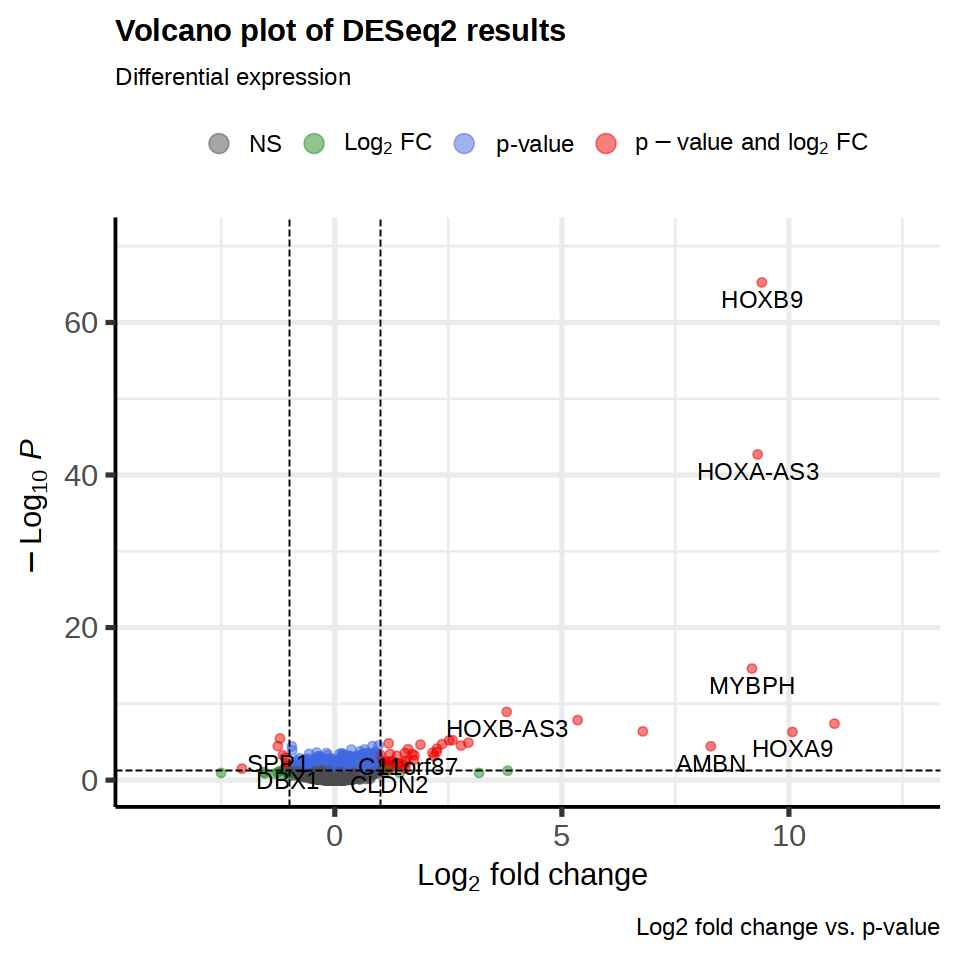

In [ ]:
# Get results
res <- res_M_RA

# Create volcano plots for differential expression results
cat("Generating volcano plots...\n")

# Function to create enhanced volcano plots
create_volcano_plot <- function(results, title_suffix, y_variable = "pvalue") {
  options(repr.plot.width=CONFIG$plot_width, repr.plot.height=CONFIG$plot_height)
  
  volcano_plot <- EnhancedVolcano(results,
                                 lab = rownames(results),
                                 x = 'log2FoldChange',
                                 y = y_variable,
                                 pCutoff = CONFIG$p_cutoff,
                                 FCcutoff = CONFIG$fc_cutoff,
                                 title = paste('Volcano Plot -', title_suffix),
                                 subtitle = 'Differential Expression Analysis',
                                 caption = paste('Log2 fold change vs.', y_variable))
  
  print(volcano_plot)
  return(volcano_plot)
}

# Generate volcano plots for available results
if (exists("de_results_ra")) {
  cat("Creating volcano plots for M_RA...\n")
  volcano_ra_raw <- create_volcano_plot(de_results_ra$raw, "M_RA (Raw)", "pvalue")
  volcano_ra_shrunk <- create_volcano_plot(de_results_ra$shrunk, "M_RA (Shrunk)", "pvalue")
}

if (exists("de_results_chir")) {
  cat("Creating volcano plots for M_CHIR...\n")
  volcano_chir_shrunk <- create_volcano_plot(de_results_chir$shrunk, "M_CHIR (Shrunk)", "svalue")
}

cat("Volcano plot generation completed\n")



## Analysis Summary and Session Information

In [ ]:
# Analysis Summary
cat("=== STABILITY TIME ANALYSIS WITH SINGLE CELL DATA - SUMMARY ===\n\n")

cat("Data Processing:\n")
cat("- Input samples:", ncol(data), "\n")
cat("- Filtered samples:", ncol(filtered_data), "\n")
cat("- Input genes:", nrow(data), "\n")
cat("- Filtered genes:", nrow(dds), "\n")

cat("\nTransformations Applied:\n")
cat("- Variance stabilizing transformation (VST)\n")
cat("- Batch corrections: sample, time, genotype effects\n")

cat("\nOutputs Generated:\n")
cat("- Normalized count matrices\n")
cat("- VST-transformed data (multiple corrections)\n")
cat("- Sample distance matrices\n")
cat("- Marker gene distance matrices\n")
cat("- Differential expression results\n")
cat("- Quality control plots\n")
cat("- PCA plots\n")
cat("- Volcano plots\n")
cat("- Sample distance heatmaps\n")

if (exists("de_results_ra")) {
  sig_genes_ra <- sum(de_results_ra$raw$pvalue < CONFIG$p_cutoff, na.rm=TRUE)
  cat("\nDifferential Expression Results:\n")
  cat("- M_RA significant genes:", sig_genes_ra, "\n")
}

if (exists("de_results_chir")) {
  sig_genes_chir <- sum(de_results_chir$raw$pvalue < CONFIG$p_cutoff, na.rm=TRUE)
  cat("- M_CHIR significant genes:", sig_genes_chir, "\n")
}

cat("\n=== SESSION INFO ===\n")
sessionInfo()

cat("\n=== ANALYSIS COMPLETED SUCCESSFULLY ===\n")
cat("Timestamp:", Sys.time(), "\n")